Celda 1: Importación y preparación de datos

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import os

# Preparar texto y vocabulario
sentence = "The black cat sat on the couch and the brown dog slept on the rug".lower().split()
vocab = sorted(set(sentence))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocab)

def generate_skipgram_data(words, window_size=2):
    pairs = []
    for idx, word in enumerate(words):
        for j in range(-window_size, window_size + 1):
            if j == 0 or idx + j < 0 or idx + j >= len(words):
                continue
            pairs.append((word, words[idx + j]))
    return [(word2idx[t], word2idx[c]) for t, c in pairs]

training_pairs = generate_skipgram_data(sentence)
targets, contexts = zip(*training_pairs)
targets = np.array(targets)
contexts = np.array(contexts)


Celda 2: Definición del modelo Skip-Gram

In [5]:
class SkipGramModel(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=1)
        self.output_layer = layers.Dense(vocab_size, activation='softmax')

    def call(self, x):
        x = self.embedding(x)
        x = tf.squeeze(x, axis=1)
        return self.output_layer(x)

embedding_dim = 15
model = SkipGramModel(vocab_size, embedding_dim)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


Celda 3: Entrenamiento del modelo

In [6]:
# Reshape para que cada target sea de tamaño (batch_size, 1)
targets = targets.reshape(-1, 1)
model.fit(targets, contexts, epochs=100, verbose=0)
print("Modelo entrenado")


Modelo entrenado


Celda 4: Guardar embeddings en CSV

In [7]:
embeddings = model.embedding.get_weights()[0]
df_embeddings = pd.DataFrame(embeddings, index=vocab)
df_embeddings.to_csv("word_embeddings.csv")
print("Embeddings guardados en 'word_embeddings.csv'")


Embeddings guardados en 'word_embeddings.csv'


Celda 5: Calcular similitud entre palabras

In [10]:
similarity_matrix = cosine_similarity(embeddings)
print("\n🔍 Similitud de coseno entre algunas palabras:\n")

#words_to_compare = ["black", "brown"]
#words_to_compare = ["black", "one"]
words_to_compare = ["black", "brown", "cat", "dog", "rug", "couch"]
for i, word1 in enumerate(words_to_compare):
    for word2 in words_to_compare[i+1:]:
        sim = cosine_similarity(
            [embeddings[word2idx[word1]]],
            [embeddings[word2idx[word2]]]
        )[0][0]
        print(f"Sim('{word1}', '{word2}') = {sim:.4f}")



🔍 Similitud de coseno entre algunas palabras:

Sim('black', 'brown') = -0.0569
Sim('black', 'cat') = 0.5269
Sim('black', 'dog') = -0.1365
Sim('black', 'rug') = 0.4662
Sim('black', 'couch') = 0.4481
Sim('brown', 'cat') = -0.5556
Sim('brown', 'dog') = -0.1787
Sim('brown', 'rug') = -0.3944
Sim('brown', 'couch') = -0.0755
Sim('cat', 'dog') = 0.1035
Sim('cat', 'rug') = 0.6310
Sim('cat', 'couch') = 0.5238
Sim('dog', 'rug') = 0.6660
Sim('dog', 'couch') = 0.5444
Sim('rug', 'couch') = 0.9046


 Celda 6: Guardar el modelo

In [11]:
model_save_path = "skipgram_model"
model.save(model_save_path)
print(f"\n Modelo guardado en: '{model_save_path}'")


INFO:tensorflow:Assets written to: skipgram_model\assets

 Modelo guardado en: 'skipgram_model'


 Celda 7: Cargar el modelo e inferir embeddings

In [12]:
loaded_model = tf.keras.models.load_model(model_save_path)

def get_word_embedding(word):
    idx = word2idx[word]
    embedding = loaded_model.embedding(tf.constant([idx]))
    return embedding.numpy()[0]

black_vector = get_word_embedding("black")
brown_vector = get_word_embedding("brown")

print(f"\n Embedding de 'black' desde modelo guardado:\n{black_vector}")
print(f"\n Embedding de 'brown' desde modelo guardado:\n{brown_vector}")




 Embedding de 'black' desde modelo guardado:
[-0.18853325  0.01204001  0.10546672  0.00733518 -0.03893225  0.11211638
 -0.20876372 -0.14854692 -0.13516533  0.08624694  0.07322759  0.14403193
 -0.17268635  0.01043693  0.16071762]

 Embedding de 'brown' desde modelo guardado:
[ 0.02440731 -0.18290669  0.04255658  0.18908665  0.06617628  0.06464063
  0.06916575  0.01157813  0.01317491  0.1323464  -0.08307938 -0.08484653
 -0.06567439 -0.00605046  0.00142913]


Celda 8: Visualización de embeddings con t-SNE

C:\Users\eacar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\eacar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


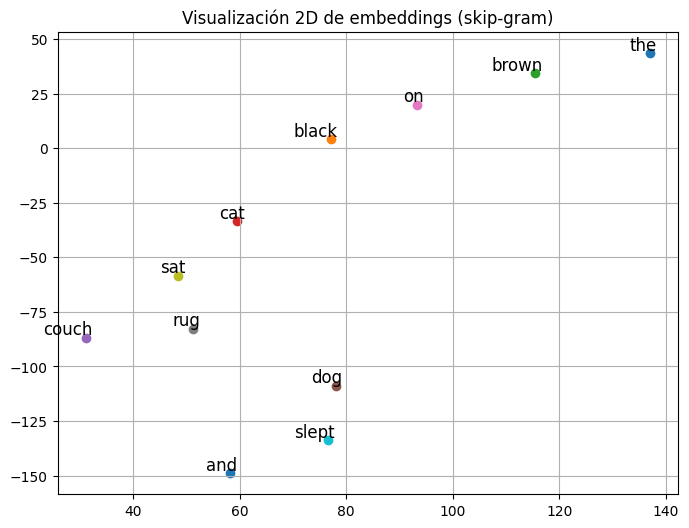

In [13]:
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i, label in enumerate(vocab):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5, 2), ha='right', fontsize=12)

plt.title("Visualización 2D de embeddings (skip-gram)")
plt.grid(True)
plt.show()


In [14]:
loaded_model.summary()

Model: "skip_gram_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  165       
                                                                 
 dense_1 (Dense)             multiple                  176       
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
